# Importing Dependencies:
---

In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.applications import EfficientNetV2S
import seaborn as sns

# Examining The Data:
---

In [3]:
training_directory = 'Training'
testing_directory = 'Testing'
x_train = []
y_train = []
x_test = []
y_test = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

for label in labels:
    directory = os.path.join(training_directory, label)
    for i in os.listdir(directory):
        img = cv2.imread(os.path.join(directory,i))
        img = cv2.resize(img,(150, 150))
        x_train.append(img)
        y_train.append(label)

for label in labels:
    directory = os.path.join(testing_directory, label)
    for i in os.listdir(directory):
        img = cv2.imread(os.path.join(directory,i))
        img = cv2.resize(img,(150, 150))
        x_test.append(img)
        y_test.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [4]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (2870, 150, 150, 3)
y_train shape: (2870,)
x_test shape: (394, 150, 150, 3)
y_test shape: (394,)


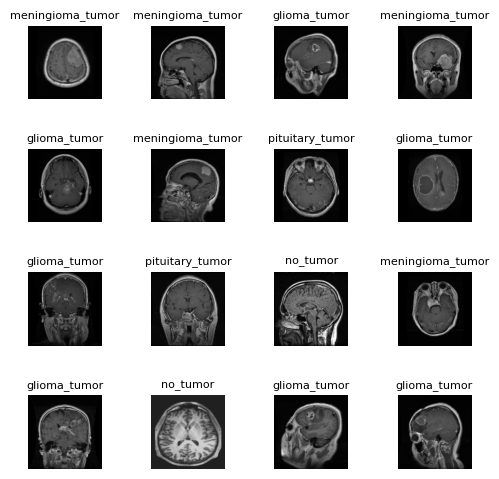

In [5]:
# Visualizing the training data:
m,n = len(x_train), len(y_train)

fig, ax = plt.subplots(4,4,figsize=(5,5))
fig.tight_layout(pad=0.5)

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    ax.imshow(x_train[rand])
    ax.set_title(y_train[rand], {'fontsize':8})
    ax.set_axis_off()

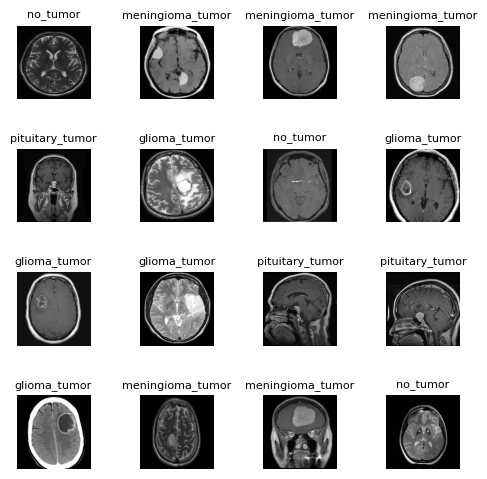

In [6]:
# Visualizing the testing data:
m,n = len(x_test), len(y_test)

fig, ax = plt.subplots(4,4,figsize=(5,5))
fig.tight_layout(pad=0.5)

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    ax.imshow(x_test[rand])
    ax.set_title(y_test[rand], {'fontsize':8})
    ax.set_axis_off()

In [7]:
# One hot encoding the categorical variables
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Transfer Learning:
---

In [12]:
# The EfficientNetV2L architecture:
effnet = EfficientNetV2S(weights='imagenet',include_top=False,input_shape=(150, 150,3))

82420632/82420632 [==============================] - 5s 0us/step


In [13]:
# Building the model:
x = effnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.97)(x)
x = tf.keras.layers.Dense(4, 'softmax')(x)
model = tf.keras.models.Model(inputs = effnet.input, outputs = x)

# Training The Model:
---

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=15, validation_data = (x_test, y_test))

Epoch 1/15
90/90 [==============================] - 116s 327ms/step - loss: 0.2544 - accuracy: 0.9268 - val_loss: 0.0777 - val_accuracy: 0.9756
Epoch 2/15
90/90 [==============================] - 24s 264ms/step - loss: 0.1749 - accuracy: 0.9470 - val_loss: 0.0154 - val_accuracy: 0.9965
Epoch 3/15
90/90 [==============================] - 24s 263ms/step - loss: 0.1434 - accuracy: 0.9624 - val_loss: 0.0359 - val_accuracy: 0.9895
Epoch 4/15
90/90 [==============================] - 24s 264ms/step - loss: 0.1503 - accuracy: 0.9540 - val_loss: 0.1057 - val_accuracy: 0.9617
Epoch 5/15
90/90 [==============================] - 24s 264ms/step - loss: 0.1478 - accuracy: 0.9610 - val_loss: 0.0450 - val_accuracy: 0.9791
Epoch 6/15
90/90 [==============================] - 24s 264ms/step - loss: 0.0823 - accuracy: 0.9763 - val_loss: 0.0100 - val_accuracy: 0.9965
Epoch 7/15
90/90 [==============================] - 24s 263ms/step - loss: 0.0757 - accuracy: 0.9819 - val_loss: 0.0865 - val_accuracy: 0.979

# Visualizing The Performance:
---

Text(0, 0.5, 'Training & Validation Loss')

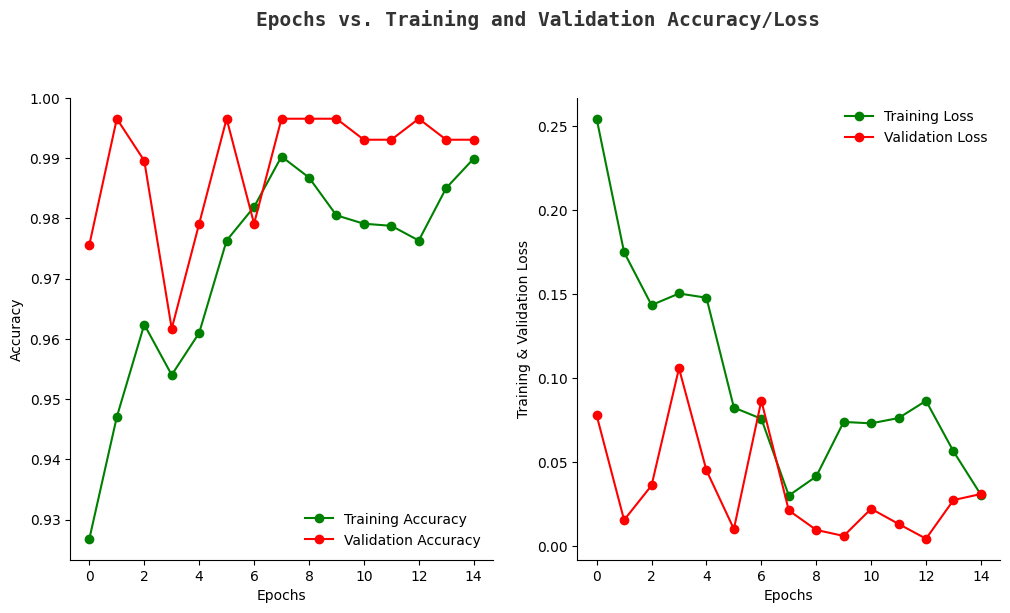

In [29]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = [i for i in range(15)]

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=14,fontweight='bold',
             fontname='monospace',color='black',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='g',color='g',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='r',color='r',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor='g',color='g',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor='r',color='r',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

In [36]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

13/13 [==============================] - 1s 65ms/step


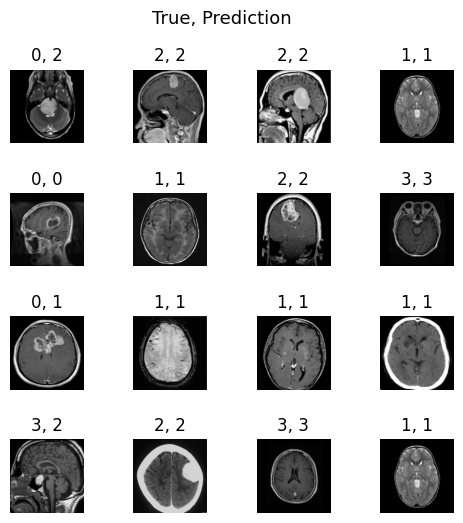

In [37]:
m = x_test.shape[0]

fig, ax = plt.subplots(4,4,figsize=(5,5))
fig.tight_layout(pad=0.5)

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    ax.imshow(x_test[rand])
    ax.set_title(f'{y_test[rand].argmax()}, {pred[rand]}')
    ax.set_axis_off()
    
fig.suptitle('True, Prediction\n\n\n\n', fontsize=13, va='center');
plt.savefig('Results.png')